In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [86]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # GPU를 비활성화

In [1]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

output_dir = "myLearningData/savefig/3line/LargeData/fine"  # 저장할 폴더 이름
if not os.path.exists(output_dir): # 폴더가 없는 경우 폴더를 생성합니다.
    os.makedirs(output_dir)
data = '231215_1947_4kPa_6.5V_3line_100ms_Data_filtered'
datanickname = 'PReLU_N64Op3LR6Adam_w0_woForce'
dataname = data+datanickname
filename = 'myData/'+data+'.csv'
SDreal = pd.read_csv(filename)
SDreal=SDreal.iloc[:,:40]
SDreal.describe()

Sx00           Sx01           Sx02           Sx03  \
count  364868.000000  364868.000000  364868.000000  364868.000000   
mean       68.289575      67.284917      60.541315      64.823814   
std         1.570471       1.810397       1.387633       1.561984   
min        47.540000      44.770000      45.500000      48.200000   
25%        67.810000      66.680000      59.810000      64.450000   
50%        68.450000      67.590000      60.600000      65.020000   
75%        69.100000      68.330000      61.410000      65.580000   
max        72.420000      72.070000      68.460000      69.740000   

                Sx04           Sx05           Sx06           Sx07  \
count  364868.000000  364868.000000  364868.000000  364868.000000   
mean       55.582825      64.043173      66.346227      66.994958   
std         1.529354       2.004593       2.500575       1.518290   
min        39.880000      40.500000      43.720000      46.260000   
25%        55.210000      63.620000      65.640000      66.600000   
50%        55.810000      64.290000      66.900000      67.180000   
75%        56.370000      64.980000      67.830000      67.730000   
max        59.800000      69.910000      72.260000      71.930000   

                Sx10           Sx11  ...           Sx46           Sx47  \
count  364868.000000  364868.000000  ...  364868.000000  364868.000000   
mean       70.152089      57.632081  ...      60.958665      58.183002   
std         1.600796       1.254126  ...       1.652195       1.691277   
min        50.760000      40.220000  ...      41.160000      37.010000   
25%        69.530000      57.150000  ...      60.540000      57.800000   
50%        70.320000      57.670000  ...      61.220000      58.420000   
75%        71.040000      58.200000  ...      61.820000      59.010000   
max        74.600000      66.140000  ...      65.190000      64.310000   

                Sx50           Sx51          Sx52           Sx53  \
count  364868.000000  364868.000000  364868.00000  364868.000000   
mean       59.840473      61.147401      59.34898      66.295371   
std         1.626354       2.065369       1.39680       1.575540   
min        41.800000      39.380000      42.21000      46.510000   
25%        59.250000      60.870000      58.89000      65.720000   
50%        60.020000      61.520000      59.50000      66.480000   
75%        60.720000      62.120000      60.09000      67.180000   
max        66.710000      66.060000      64.35000      71.010000   

               Force              z          theta              r  
count  364868.000000  364868.000000  364868.000000  364868.000000  
mean      115.973825      79.974763     177.502097       8.000389  
std        86.119889      48.431771     103.905118       2.582122  
min       -52.150000       0.000000       0.000000       4.000000  
25%        37.610000      40.000000      85.000000       6.000000  
50%       104.300000      80.000000     175.000000       8.000000  
75%       185.460000     120.000000     265.000000      10.000000  
max       343.260000     160.000000     355.000000      12.000000  

[8 rows x 40 columns]

In [2]:
# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

# 제거하려는 'theta'와 'z' 조합
remove_combinations = [(230, 128), (65, 144), (150, 144) ,(270, 8)]

# 각 조합에 대해 데이터 제거
for theta, z in remove_combinations:
    SDreal = SDreal[~((SDreal['theta'] == theta) & (SDreal['z'] == z))]

SDreal = SDreal[~((SDreal <= -400) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal >= 400) & (SDreal.columns == "Force")).any(axis=1)]
SDreal['Force'] = SDreal['Force'].apply(lambda x: 0 if x < 0 else x)
#SDreal = SDreal[~((SDreal <= 0) & (SDreal.columns == "Force")).any(axis=1)]

SDreal = SDreal[SDreal["r"] >= 4]
SDreal = SDreal[SDreal["r"] <= 12]

SDreal = SDreal[SDreal["z"] <= 160]
SDreal = SDreal[SDreal["z"] >= 0]

import numpy as np
toRad = np.pi/180.0
SDreal['cos']=np.cos(SDreal['theta']*toRad)
SDreal['sin']=np.sin(SDreal['theta']*toRad)
SDreal.describe()

Sx00           Sx01           Sx02           Sx03  \
count  363902.000000  363902.000000  363902.000000  363902.000000   
mean       68.290013      67.285658      60.542770      64.824501   
std         1.572025       1.811685       1.387698       1.562360   
min        47.540000      44.770000      45.500000      48.200000   
25%        67.810000      66.680000      59.810000      64.450000   
50%        68.450000      67.590000      60.610000      65.020000   
75%        69.100000      68.340000      61.410000      65.580000   
max        72.420000      72.070000      68.460000      69.740000   

                Sx04           Sx05           Sx06           Sx07  \
count  363902.000000  363902.000000  363902.000000  363902.000000   
mean       55.582680      64.043554      66.346776      66.993421   
std         1.530253       2.006650       2.501566       1.518669   
min        39.880000      40.500000      43.720000      46.260000   
25%        55.210000      63.630000      65.640000      66.600000   
50%        55.810000      64.290000      66.900000      67.180000   
75%        56.370000      64.980000      67.830000      67.720000   
max        59.800000      69.910000      72.260000      71.930000   

                Sx10           Sx11  ...           Sx50           Sx51  \
count  363902.000000  363902.000000  ...  363902.000000  363902.000000   
mean       70.151375      57.631390  ...      59.838925      61.152971   
std         1.602507       1.254532  ...       1.626102       2.054665   
min        50.760000      40.220000  ...      41.800000      39.380000   
25%        69.530000      57.150000  ...      59.250000      60.870000   
50%        70.320000      57.670000  ...      60.020000      61.520000   
75%        71.040000      58.200000  ...      60.720000      62.120000   
max        74.600000      66.140000  ...      66.710000      66.060000   

                Sx52           Sx53          Force              z  \
count  363902.000000  363902.000000  363902.000000  363902.000000   
mean       59.349176      66.298295     116.073631      79.905469   
std         1.398108       1.565705      86.099611      48.388510   
min        42.210000      46.510000       0.000000       0.000000   
25%        58.890000      65.720000      37.670000      40.000000   
50%        59.500000      66.480000     104.430000      80.000000   
75%        60.090000      67.180000     185.540000     120.000000   
max        64.350000      71.010000     343.260000     160.000000   

               theta              r           cos           sin  
count  363902.000000  363902.000000  3.639020e+05  3.639020e+05  
mean      177.499409       8.000363  6.526545e-04  2.708002e-04  
std       103.963883       2.582145  7.073415e-01  7.068736e-01  
min         0.000000       4.000000 -1.000000e+00 -1.000000e+00  
25%        86.250000       6.000000 -7.071068e-01 -7.071068e-01  
50%       175.000000       8.000000  6.123234e-17  1.224647e-16  
75%       265.000000      10.000000  7.071068e-01  7.071068e-01  
max       355.000000      12.000000  1.000000e+00  1.000000e+00  

[8 rows x 42 columns]

In [3]:
NUMSEN = 36
# 24개의 특성에 대한 평균과 표준편차를 계산합니다.
mean_values = SDreal.iloc[:, :NUMSEN].mean().values
std_values = SDreal.iloc[:, :NUMSEN].std().values

mean_values = [round(value, 2) for value in mean_values]
std_values = [round(value, 2) for value in std_values]

print("float Xmean[36] = {", ", ".join(map(str, mean_values)), "};")
print("float Xstd[36] = {", ", ".join(map(str, std_values)), "};")

min_max_F = [round(SDreal.iloc[:, NUMSEN].min(), 2), round(SDreal.iloc[:, NUMSEN].max(), 2)]
min_max_Z = [round(SDreal.iloc[:, NUMSEN+1].min(), 2), round(SDreal.iloc[:, NUMSEN+1].max(), 2)]

print("float Fminmax[2]={", ", ".join(map(str, min_max_F)), "};")
print("float Zminmax[2]={", ", ".join(map(str, min_max_Z)), "};")

float Xmean[36] = { 68.29, 67.29, 60.54, 64.82, 55.58, 64.04, 66.35, 66.99, 70.15, 57.63, 62.26, 62.02, 66.07, 56.27, 63.55, 61.44, 60.5, 51.54, 59.94, 64.85, 58.37, 52.24, 57.66, 57.41, 67.35, 66.79, 70.24, 64.52, 66.93, 57.93, 60.96, 58.18, 59.84, 61.15, 59.35, 66.3 };
float Xstd[36] = { 1.57, 1.81, 1.39, 1.56, 1.53, 2.01, 2.5, 1.52, 1.6, 1.25, 1.3, 1.4, 1.74, 1.41, 2.05, 1.69, 1.76, 1.46, 1.58, 1.99, 2.2, 2.63, 2.68, 1.62, 1.73, 1.65, 1.66, 1.84, 1.72, 1.81, 1.65, 1.69, 1.63, 2.05, 1.4, 1.57 };
float Fminmax[2]={ 0.0, 343.26 };
float Zminmax[2]={ 0, 160 };


In [100]:
def apply_transformation(df, columns, transformation):
    # columns가 제공되지 않았다면 df의 모든 칼럼을 대상으로 함
    if columns is None:
        columns = df.columns
    for column in columns:
        df[column] = transformation(df[column])
    return df

def normalize(column):
    return (column - column.min()) / (column.max() - column.min())
def standardize(column):
    return (column - column.mean()) / column.std()
def submean(column):
    return (column - column.mean())
def normalize_to_neg1_to_1(column):
    normalized = (column - column.min()) / (column.max() - column.min())  # Min-Max normalization (0 to 1)
    return (normalized - 0.5) * 2  # Transform to -1 to 1


SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], normalize_to_neg1_to_1)
SDreal.describe()

Sx00           Sx01           Sx02           Sx03  \
count  363902.000000  363902.000000  363902.000000  363902.000000   
mean       68.290013      67.285658      60.542770      64.824501   
std         1.572025       1.811685       1.387698       1.562360   
min        47.540000      44.770000      45.500000      48.200000   
25%        67.810000      66.680000      59.810000      64.450000   
50%        68.450000      67.590000      60.610000      65.020000   
75%        69.100000      68.340000      61.410000      65.580000   
max        72.420000      72.070000      68.460000      69.740000   

                Sx04           Sx05           Sx06           Sx07  \
count  363902.000000  363902.000000  363902.000000  363902.000000   
mean       55.582680      64.043554      66.346776      66.993421   
std         1.530253       2.006650       2.501566       1.518669   
min        39.880000      40.500000      43.720000      46.260000   
25%        55.210000      63.630000      65.640000      66.600000   
50%        55.810000      64.290000      66.900000      67.180000   
75%        56.370000      64.980000      67.830000      67.720000   
max        59.800000      69.910000      72.260000      71.930000   

                Sx10           Sx11  ...           Sx50           Sx51  \
count  363902.000000  363902.000000  ...  363902.000000  363902.000000   
mean       70.151375      57.631390  ...      59.838925      61.152971   
std         1.602507       1.254532  ...       1.626102       2.054665   
min        50.760000      40.220000  ...      41.800000      39.380000   
25%        69.530000      57.150000  ...      59.250000      60.870000   
50%        70.320000      57.670000  ...      60.020000      61.520000   
75%        71.040000      58.200000  ...      60.720000      62.120000   
max        74.600000      66.140000  ...      66.710000      66.060000   

                Sx52           Sx53          Force              z  \
count  363902.000000  363902.000000  363902.000000  363902.000000   
mean       59.349176      66.298295      -0.323698      -0.001182   
std         1.398108       1.565705       0.501658       0.604856   
min        42.210000      46.510000      -1.000000      -1.000000   
25%        58.890000      65.720000      -0.780516      -0.500000   
50%        59.500000      66.480000      -0.391540       0.000000   
75%        60.090000      67.180000       0.081046       0.500000   
max        64.350000      71.010000       1.000000       1.000000   

               theta              r           cos           sin  
count  363902.000000  363902.000000  3.639020e+05  3.639020e+05  
mean      177.499409       0.000091  6.526545e-04  2.708002e-04  
std       103.963883       0.645536  7.073415e-01  7.068736e-01  
min         0.000000      -1.000000 -1.000000e+00 -1.000000e+00  
25%        86.250000      -0.500000 -7.071068e-01 -7.071068e-01  
50%       175.000000       0.000000  6.123234e-17  1.224647e-16  
75%       265.000000       0.500000  7.071068e-01  7.071068e-01  
max       355.000000       1.000000  1.000000e+00  1.000000e+00  

[8 rows x 42 columns]

In [101]:
SDy = SDreal.iloc[:,36:42]
X = SDreal.iloc[:,0:36]
y = SDreal.iloc[:,[36,37,40,41]]
y

Force    z       cos       sin
0      -1.000000 -1.0  1.000000  0.000000
1      -1.000000 -1.0  1.000000  0.000000
2      -1.000000 -1.0  1.000000  0.000000
3      -1.000000 -1.0  1.000000  0.000000
4      -1.000000 -1.0  1.000000  0.000000
...          ...  ...       ...       ...
364863  0.332226  1.0  0.996195 -0.087156
364864  0.330129  1.0  0.996195 -0.087156
364865  0.328264  1.0  0.996195 -0.087156
364866  0.326458  1.0  0.996195 -0.087156
364867  0.324652  1.0  0.996195 -0.087156

[363902 rows x 4 columns]

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터 프레임 로드 (실제 데이터를 여기에 맞게 대체하세요)
# SDReal = pd.DataFrame(...)

# X와 y 분리 (y에는 'Force', 'z', 'cos', 'sin' 컬럼 포함)
X = SDreal.iloc[:, :36]
y = SDreal.iloc[:,[36,37,40,41]]

# 그룹화에 사용할 'z', 'theta', 'r' 컬럼 추가
group_columns = SDreal[['theta', 'r']]
data = pd.concat([X, group_columns, y], axis=1)

# 'z', 'theta', 'r'을 기준으로 그룹화
grouped = data.groupby(['z', 'theta', 'r'])

# 분할된 데이터를 저장할 리스트
X_train_list = []
X_valid_list = []
X_test_list = []
y_train_list = []
y_valid_list = []
y_test_list = []

# 그룹별로 데이터 분할
for _, group in grouped:
    # 그룹 데이터를 분할
    train, test = train_test_split(group, test_size=0.4, random_state=42)
    valid, test = train_test_split(test, test_size=0.5, random_state=42)
    
    # 분할된 데이터를 리스트에 추가 (X와 y를 다시 분리)
    X_train_list.append(train.iloc[:, :36])
    X_valid_list.append(valid.iloc[:, :36])
    X_test_list.append(test.iloc[:, :36])
    y_train_list.append(train[['Force', 'z', 'cos', 'sin']])
    y_valid_list.append(valid[['Force', 'z', 'cos', 'sin']])
    y_test_list.append(test[['Force', 'z', 'cos', 'sin']])

# 최종 데이터 세트 생성
X_train = pd.concat(X_train_list)
X_valid = pd.concat(X_valid_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_valid = pd.concat(y_valid_list)
y_test = pd.concat(y_test_list)

# 결과 출력
print('Train set size:', len(X_train), 'Y_train size:', len(y_train))
print('Validation set size:', len(X_valid), 'Y_valid size:', len(y_valid))
print('Test set size:', len(X_test), 'Y_test size:', len(y_test))


Train set size: 215697 Y_train size: 215697
Validation set size: 67857 Y_valid size: 67857
Test set size: 80348 Y_test size: 80348


In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/231215_1947_4kPa_6.5V_3line_100ms_Data_filteredPReLU_N64Op3LR6Adam_w0_equally_SS.pkl']

In [104]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(64, input_shape=X_train.shape[1:], kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(4)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-6))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                2368      
                                                                 
 p_re_lu_24 (PReLU)          (None, 64)                64        
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 p_re_lu_25 (PReLU)          (None, 32)                32        
                                                                 
 dense_29 (Dense)            (None, 32)                1056      
                                                                 
 p_re_lu_26 (PReLU)          (None, 32)                32        
                                                                 
 dense_30 (Dense)            (None, 32)               

## Callback (best, early stopping, tensorboard)

In [105]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'231006_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [106]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [107]:
dataname

'231215_1947_4kPa_6.5V_3line_100ms_Data_filteredPReLU_N64Op3LR6Adam_w0_equally'

In [108]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10,verbose=1,restore_best_weights = True)
n_epochs = 300
batch_size = 1
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
6741/6741 [==============================] - 83s 12ms/step - loss: 0.0681 - val_loss: 0.0518
Epoch 2/300
6741/6741 [==============================] - 83s 12ms/step - loss: 0.0500 - val_loss: 0.0525
Epoch 3/300
6741/6741 [==============================] - 86s 13ms/step - loss: 0.0463 - val_loss: 0.0457
Epoch 4/300
6741/6741 [==============================] - 87s 13ms/step - loss: 0.0440 - val_loss: 0.0488
Epoch 5/300
6741/6741 [==============================] - 85s 13ms/step - loss: 0.0423 - val_loss: 0.0457
Epoch 6/300
6741/6741 [==============================] - 86s 13ms/step - loss: 0.0408 - val_loss: 0.0409
Epoch 7/300
6741/6741 [==============================] - 86s 13ms/step - loss: 0.0399 - val_loss: 0.0411
Epoch 8/300
6741/6741 [==============================] - 86s 13ms/step - loss: 0.0392 - val_loss: 0.0394
Epoch 9/300
6741/6741 [==============================] - 81s 12ms/step - loss: 0.0387 - val_loss: 0.0418
Epoch 10/300
6741/6741 [==============================]

In [109]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v3/myModel/'+dataname+'.h5')

In [110]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)
valid_predictions_df=pd.DataFrame(valid_predictions)
#valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df.columns = ["valid_force","valid_z","valid_cos","valid_sin"]
#valid_predictions_df.columns = ["valid_z","valid_cos","valid_sin"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r","valid_cos","valid_sin"]
valid_theta_rad = np.arctan2(valid_predictions_df['valid_sin'], valid_predictions_df['valid_cos'])
valid_theta_deg = np.degrees(valid_theta_rad)
valid_predictions_df['valid_theta'] = valid_theta_deg
valid_predictions_df['valid_theta'] /= 180
valid_predictions_df['valid_square'] = valid_predictions_df['valid_cos']**2 + valid_predictions_df['valid_sin']**2
valid_predictions_df.describe()

2121/2121 [==============================] - 7s 3ms/step


valid_force       valid_z     valid_cos     valid_sin   valid_theta  \
count  67857.000000  67857.000000  67857.000000  67857.000000  67857.000000   
mean      -0.329216      0.004948      0.010620     -0.021722     -0.012449   
std        0.424417      0.571370      0.689752      0.701328      0.572196   
min       -1.057873     -1.053016     -1.158698     -1.199930     -0.999917   
25%       -0.712483     -0.504119     -0.652692     -0.708768     -0.516160   
50%       -0.427986      0.022597     -0.034579     -0.010796     -0.006847   
75%        0.022074      0.492628      0.689615      0.661433      0.506703   
max        0.796773      1.464562      1.253481      1.114993      0.999978   

       valid_square  
count  67857.000000  
mean       0.968190  
std        0.163881  
min        0.001426  
25%        0.892879  
50%        0.981788  
75%        1.067326  
max        1.739544

In [111]:
k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
k_df.columns  = ["force","z","cos","sin"]
#k_df.columns  = ["z","cos","sin"]

#k_df.columns  = ["force","z","r","cos","sin"]
theta_rad = np.arctan2(k_df['sin'], k_df['cos'])
theta_deg = np.degrees(theta_rad)
k_df['theta'] = theta_deg
k_df['theta'] /= 180
k_df['square'] = k_df['cos']*k_df['cos'] + k_df['sin']*k_df['sin']
k_df

force    z       cos       sin     theta  square
0     -1.000000 -1.0  1.000000  0.000000  0.000000     1.0
1     -1.000000 -1.0  1.000000  0.000000  0.000000     1.0
2     -1.000000 -1.0  1.000000  0.000000  0.000000     1.0
3     -1.000000 -1.0  1.000000  0.000000  0.000000     1.0
4     -1.000000 -1.0  1.000000  0.000000  0.000000     1.0
...         ...  ...       ...       ...       ...     ...
67852  0.328264  1.0  0.996195 -0.087156 -0.027778     1.0
67853  0.356989  1.0  0.996195 -0.087156 -0.027778     1.0
67854  0.421838  1.0  0.996195 -0.087156 -0.027778     1.0
67855  0.326458  1.0  0.996195 -0.087156 -0.027778     1.0
67856  0.350755  1.0  0.996195 -0.087156 -0.027778     1.0

[67857 rows x 6 columns]

In [112]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr_matrix = pd.DataFrame(index=k_df.columns, columns=valid_predictions_df.columns)
loss= model.evaluate(X_valid, y_valid)
print("검증 손실:", round(loss,4))
avg = valid_predictions_df['valid_square'].mean()
std = valid_predictions_df['valid_square'].std()
n = 1.5  # adjust the offset value as needed
print("avg:",round(avg,2),"std:",round(std,2),"      ",round(avg - n*std,2),round(avg + n*std,2))
# 각 열과 행의 상관관계 계산
for k_col in k_df.columns:
    for valid_col in valid_predictions_df.columns:
        corr2 = np.corrcoef(k_df[k_col], valid_predictions_df[valid_col])[0, 1]
        corr_matrix.loc[k_col, valid_col] = corr2
corr_matrix

corr
87.95% force
97.96% z
96.76% cos
96.70% sin
85.51% theta
-6.50% square
2121/2121 [==============================] - 10s 4ms/step - loss: 0.0345
검증 손실: 0.0345
avg: 0.97 std: 0.16        0.72 1.21


valid_force   valid_z valid_cos valid_sin valid_theta valid_square
force     0.879491  0.186113 -0.003871  0.009992   -0.007896      0.41491
z         0.212629  0.979614  0.015634  0.022037    0.004862     0.239264
cos      -0.034094  0.023944  0.967607  0.007076    0.008801     0.045607
sin       0.007658 -0.014069  0.035566  0.966991    0.752473    -0.166555
theta     0.002567 -0.008931  0.004793  0.754561     0.85511    -0.279406
square    -0.00484 -0.003456 -0.047824 -0.014857   -0.058374      0.01613

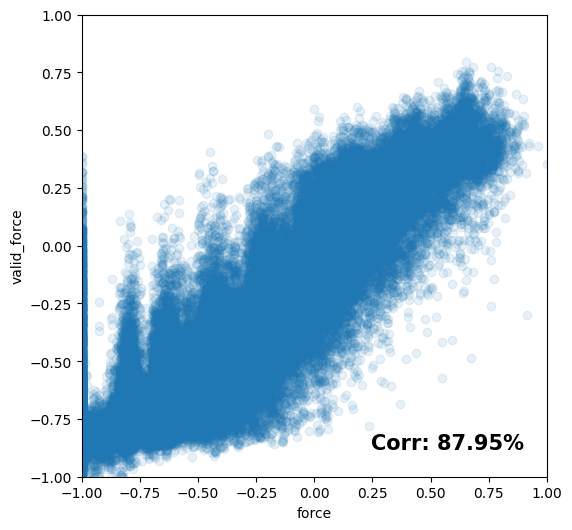

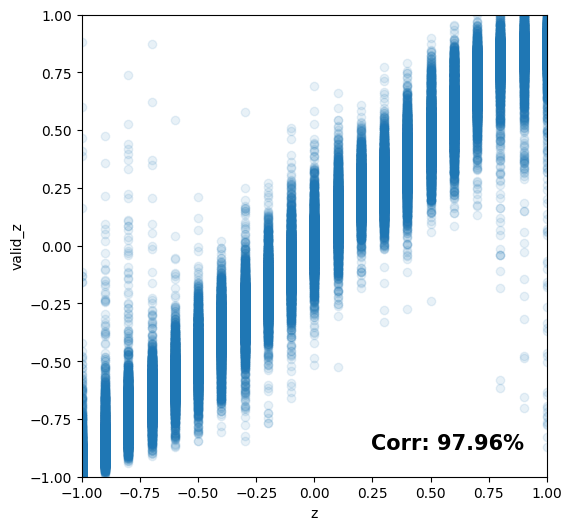

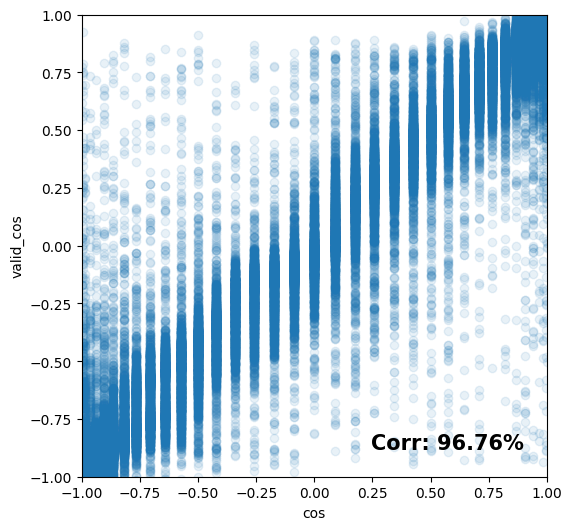

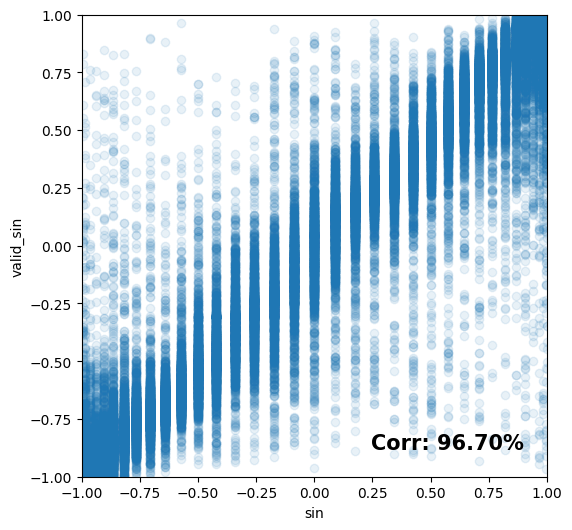

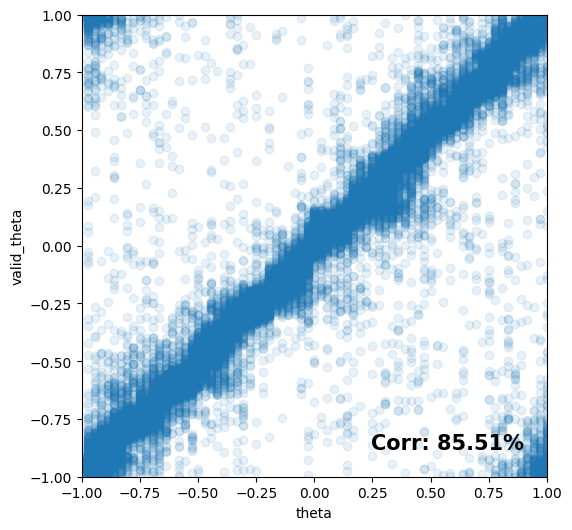

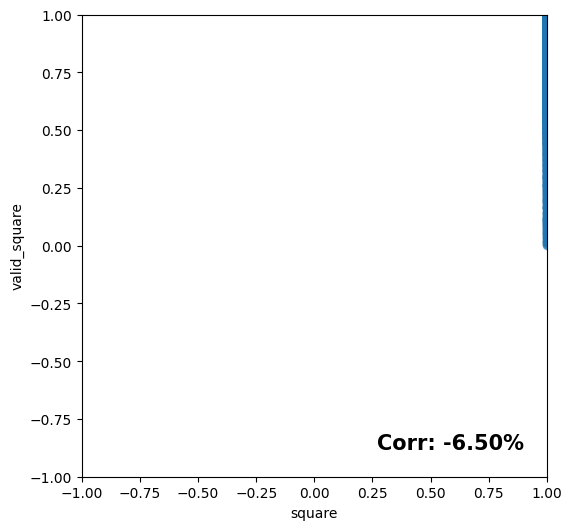

In [113]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['force','z','cos','sin','theta','square']
#fields = ['force','z','r','cos','sin','theta']
#fields = ['z','cos','sin','theta','square']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-1, 1)  # x축 범위 설정
    plt.ylim(-1, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()


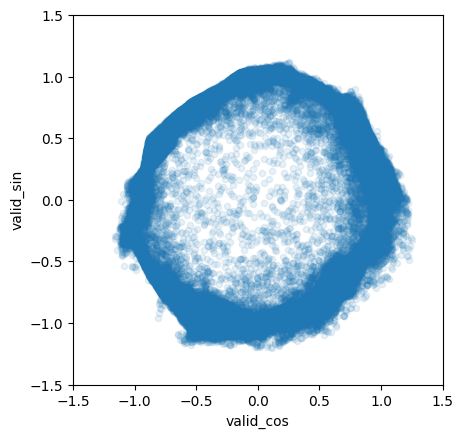

In [114]:
alpa = 0.1  # assuming you've set alpha to this value, adjust as needed
ax = ValidPre.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpa)

# Set the aspect ratio to be equal
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

# Display the plot
plt.show()

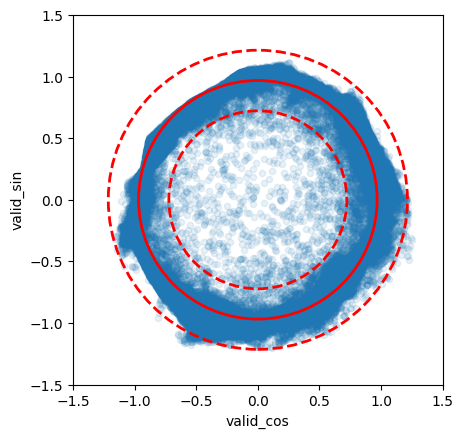

In [115]:
alpha = 0.1  # set alpha value for scatter plot
ax = ValidPre.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)


# Draw offset circles (one inside and one outside the main circle)

circle = plt.Circle((0, 0), avg, color='r', fill=False, linewidth=2)
ax.add_artist(circle)
inner_circle = plt.Circle((0, 0), avg - n*std, color='r', linestyle='--', fill=False, linewidth=2)
outer_circle = plt.Circle((0, 0), avg + n*std, color='r', linestyle='--', fill=False, linewidth=2)
ax.add_artist(inner_circle)
ax.add_artist(outer_circle)

# Set the aspect ratio to be equal
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
# Display the plot
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_offset.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

plt.show()


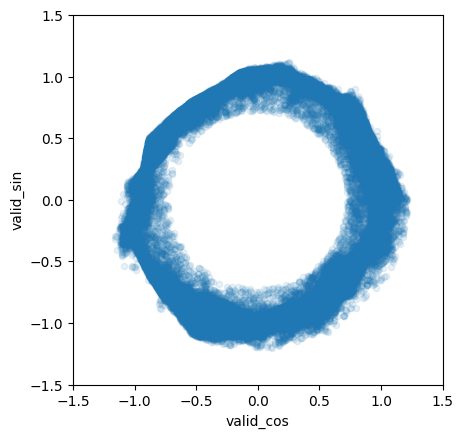

2.0720043621144466

In [116]:
ValidPre_filtered = ValidPre[
    (ValidPre['valid_cos']**2 + ValidPre['valid_sin']**2 <= (avg + n*std)**2) &
    (ValidPre['valid_cos']**2 + ValidPre['valid_sin']**2 >= (avg - n*std)**2)
]


ax = ValidPre_filtered.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_cut.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

plt.show()

total_data_count = len(ValidPre)
filtered_data_count = len(ValidPre_filtered)
percentage_filtered_out = ((total_data_count - filtered_data_count) / total_data_count) * 100
percentage_filtered_out

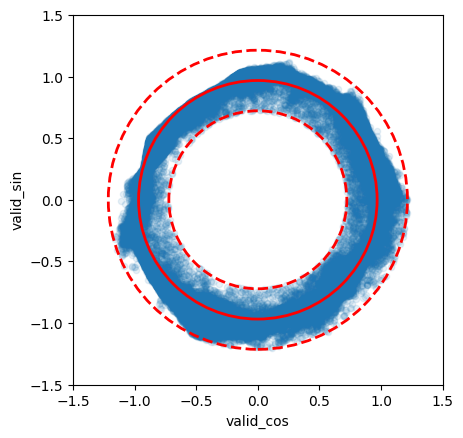

In [117]:
# 기존의 scatter plot을 그립니다.
ax = ValidPre_filtered.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)



# 점선 원을 추가합니다. 하나는 내부에, 하나는 외부에 위치합니다.
circle = plt.Circle((0, 0), avg, color='r', fill=False, linewidth=2)
inner_circle = plt.Circle((0, 0), avg - n*std, color='r', linestyle='--', fill=False, linewidth=2)
outer_circle = plt.Circle((0, 0), avg + n*std, color='r', linestyle='--', fill=False, linewidth=2)
ax.add_artist(circle)
ax.add_artist(inner_circle)
ax.add_artist(outer_circle)

# 그래프의 비율을 1:1로 설정합니다.
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정

# 그래프를 파일로 저장합니다.
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_cut_offset.png"))

# 그래프를 출력합니다.
plt.show()


진행 상태: 100.00%

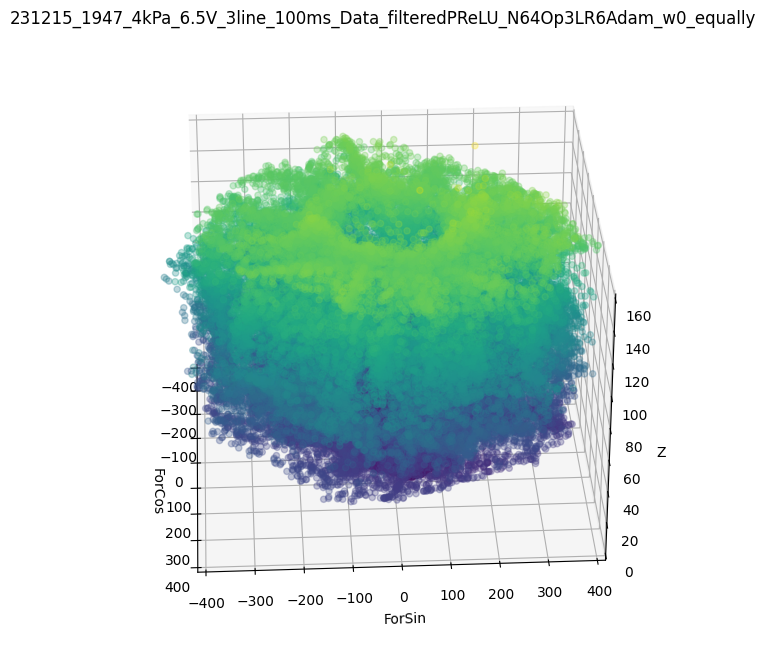

In [118]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()

# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 'Inferno' 색상 맵 적용
cmap = plt.cm.viridis

# z 값을 0과 1 사이로 정규화
norm_z = (ValidPre['valid_z'] - ValidPre['valid_z'].min()) / (ValidPre['valid_z'].max() - ValidPre['valid_z'].min())

# 색상 맵 적용
colors = cmap(norm_z)


# 최소값과 최대값
min_value = min_max_F[0]
max_value = min_max_F[1]

# 원래 값으로 변환
Force = ((ValidPre['valid_force']/2+0.5) * (max_value - min_value)) + min_value  +110
cos = Force*ValidPre['valid_cos']
sin =  Force*ValidPre['valid_sin']
z = ((ValidPre['valid_z']/2+0.5) * (min_max_Z[1] - min_max_Z[0])) + min_max_Z[0] 


ax.scatter(cos, sin, z, c=colors, alpha=0.3)

# 축 레이블 및 한계 설정
ax.set_xlabel('ForCos')
ax.set_ylabel('ForSin')
ax.set_zlabel('Z')
ax.set_xlim([-400, 400])
ax.set_ylim([-400, 400])
ax.set_zlim([0, 160])
ax.set_title(dataname)



 

# 애니메이션 생성 및 저장
nSteps = 3
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)

ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)
ani.save(os.path.join(output_dir, f"{dataname}_3d_scatter_valid_force_color.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))

# 결과 확인
plt.show()


진행 상태: 100.00%

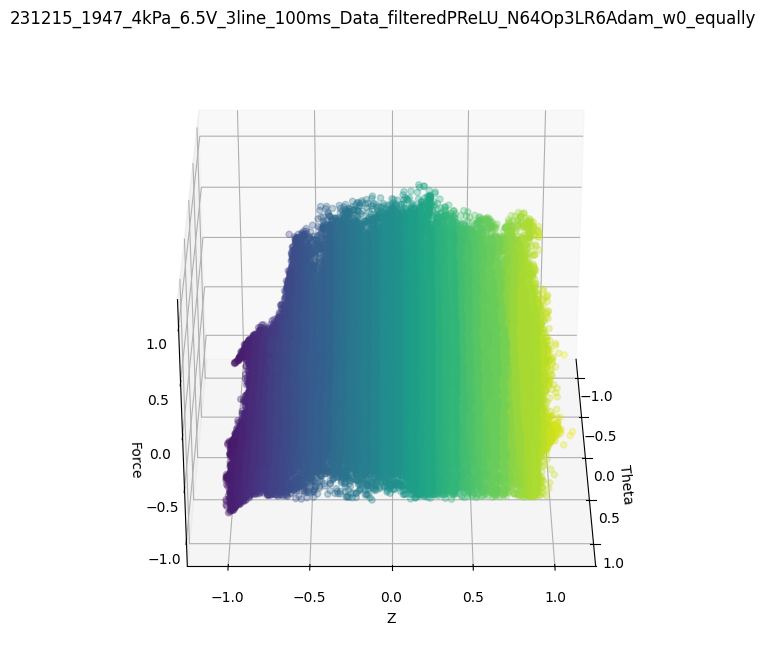

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()
    
    
# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

z_bins = np.arange(-1.2, 1.2, 0.05)

z_indices = np.digitize(ValidPre['valid_z'], z_bins)

# 색상 맵 설정
colors = plt.cm.viridis(np.linspace(0, 1, len(z_bins)))

# 3D 스캐터 플롯 생성
# 각 점에 색상 배열을 적용하기 위해 z_indices-1을 사용
for i in range(1, len(z_bins)):
    subset = ValidPre[z_indices == i]
    ax.scatter(subset['valid_theta'], subset['valid_z'], subset['valid_force'], color=colors[i-1], alpha=0.3)

# 축 레이블 설정
ax.set_xlabel('Theta')
ax.set_ylabel('Z')
ax.set_zlabel('Force')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])
ax.set_title(dataname)


nSteps = 3
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)
# GIF 애니메이션 생성
ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)

# GIF 저장
ani.save(os.path.join(output_dir, f"{dataname}_Ref_plane.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))


In [120]:
import pandas as pd
from sklearn.cross_decomposition import CCA

# 가정: 'ValidPre' 데이터프레임은 이미 로드되어 있고, 필요한 모든 원시 데이터를 포함하고 있음

# Force, cos, sin, z 값 계산 - 첫 번째 데이터 세트
Force1 = ((ValidPre['valid_force']/2 + 0.5) * (max_value - min_value)) + min_value + 110
cos1 = Force1 * ValidPre['valid_cos']
sin1 = Force1 * ValidPre['valid_sin']
z1 = ((ValidPre['valid_z']/2 + 0.5) * (152 - 8)) + 8

# Force, cos, sin, z 값 계산 - 두 번째 데이터 세트
Force2 = ((ValidPre['force']/2 + 0.5) * (max_value - min_value)) + min_value + 110
cos2 = Force2 * ValidPre['cos']
sin2 = Force2 * ValidPre['sin']
z2 = ((ValidPre['z']/2 + 0.5) * (152 - 8)) + 8

# 데이터프레임 생성
df1 = pd.DataFrame({'ForceCos': Force1*cos1, 'ForceSin': Force1*sin1, 'Z': z1})
df2 = pd.DataFrame({'ForceCos': Force2*cos2, 'ForceSin': Force2*sin2, 'Z': z2})

# 캐노니컬 상관 분석 (CCA) 수행
# CCA 인스턴스 생성, 여기서 n_components는 분석할 컴포넌트 수, 두 데이터 세트의 변수 수에 맞게 설정
cca = CCA(n_components=min(df1.shape[1], df2.shape[1]))

# CCA 적합
cca.fit(df1, df2)

# 결과 변환
df1_c, df2_c = cca.transform(df1, df2)

# CCA 결과 출력
print("Canonical Correlation per component:")
for i, (cc1, cc2) in enumerate(zip(df1_c.T, df2_c.T), start=1):
    corr = np.corrcoef(cc1, cc2)[0, 1]
    print(f"Component {i}: {corr:.3f}")


Canonical Correlation per component:
Component 1: 0.980
Component 2: 0.958
Component 3: 0.957


진행 상태: 100.00%

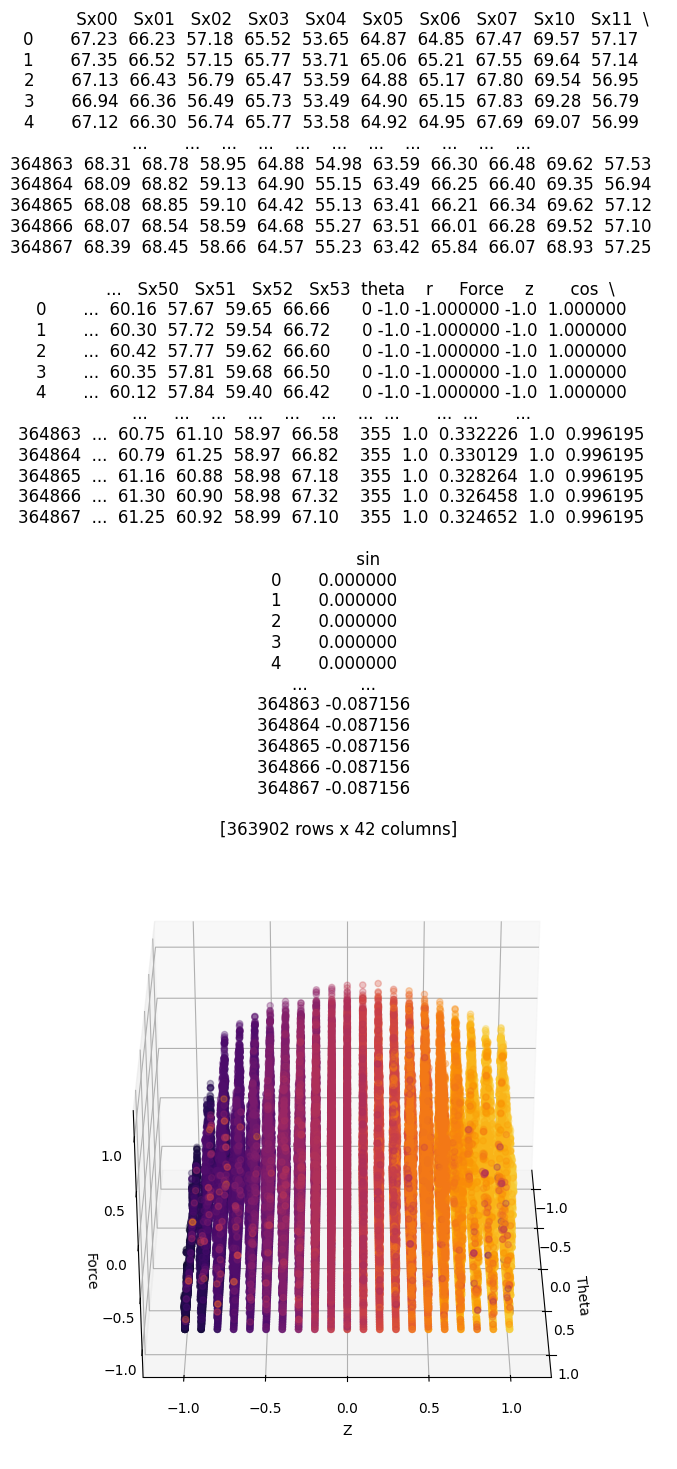

In [121]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()
    
# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

z_bins = np.arange(-1.2, 1.2, 0.05)

z_indices = np.digitize(ValidPre['valid_z'], z_bins)

# 색상 맵 설정
colors = plt.cm.inferno(np.linspace(0, 1, len(z_bins)))

# 3D 스캐터 플롯 생성
# 각 점에 색상 배열을 적용하기 위해 z_indices-1을 사용
for i in range(1, len(z_bins)):
    subset = ValidPre[z_indices == i]
    ax.scatter(subset['theta'], subset['z'], subset['force'], color=colors[i-1], alpha=0.3)

# 축 레이블 설정
ax.set_xlabel('Theta')
ax.set_ylabel('Z')
ax.set_zlabel('Force')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])
ax.set_title(data)


nSteps = 3
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)
# GIF 애니메이션 생성
ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)

# GIF 저장
ani.save(os.path.join(output_dir, f"{dataname}_Ref.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))


진행 상태: 100.00%

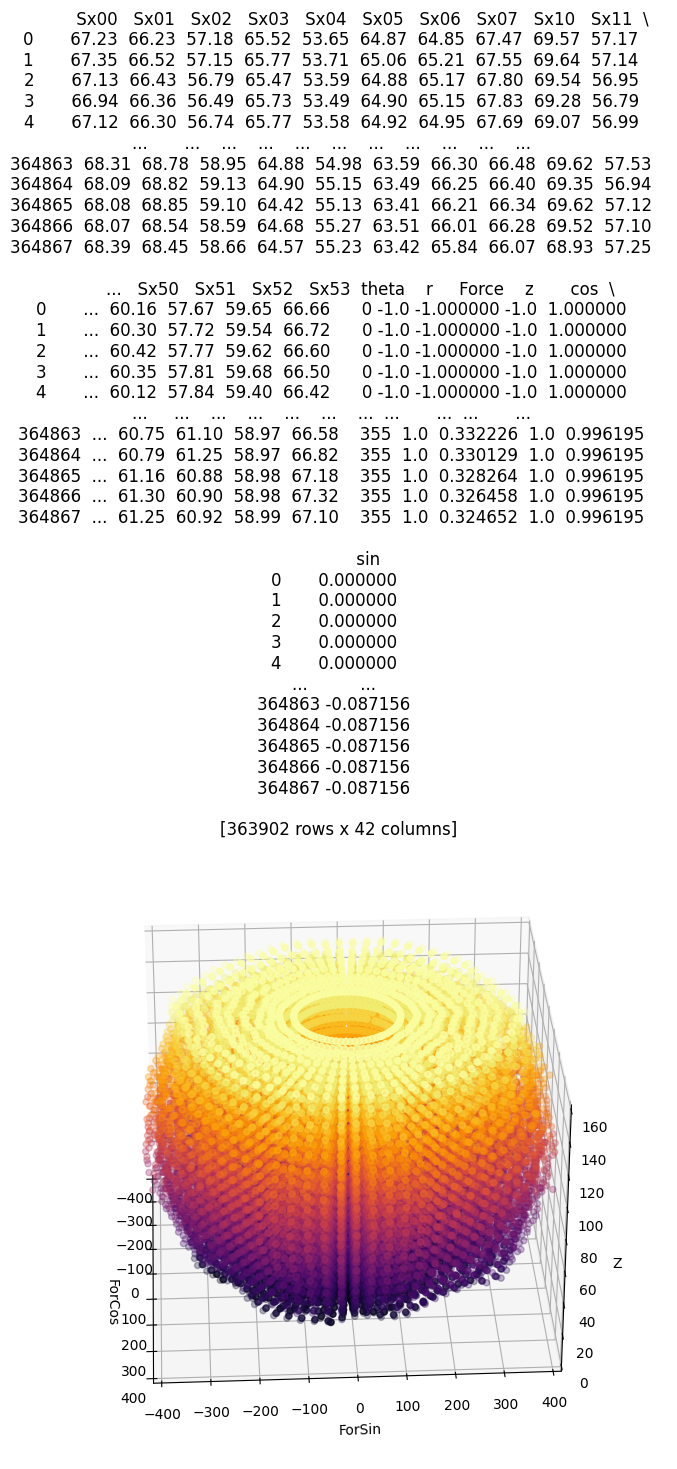

In [122]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()

# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 'Inferno' 색상 맵 적용
cmap = plt.cm.inferno

# z 값을 0과 1 사이로 정규화
norm_z = (ValidPre['z'] - ValidPre['z'].min()) / (ValidPre['z'].max() - ValidPre['z'].min())

# 색상 맵 적용
colors = cmap(norm_z)


# 최소값과 최대값
min_value = min_max_F[0]
max_value = min_max_F[1]

# 원래 값으로 변환
Force = ((ValidPre['force']/2+0.5) * (max_value - min_value)) + min_value  +110
cos = Force*ValidPre['cos']
sin =  Force*ValidPre['sin']
z = ((ValidPre['z']/2+0.5) * (min_max_Z[1] - min_max_Z[0])) + min_max_Z[0] 


ax.scatter(cos, sin, z, c=colors, alpha=0.3)

# 축 레이블 및 한계 설정
ax.set_xlabel('ForCos')
ax.set_ylabel('ForSin')
ax.set_zlabel('Z')
ax.set_xlim([-400, 400])
ax.set_ylim([-400, 400])
ax.set_zlim([0, 160])
ax.set_title(data)

 

# 애니메이션 생성 및 저장
nSteps = 3
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)

ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)
ani.save(os.path.join(output_dir, f"{dataname}_3d_scatter_Ref_force_color.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))

# 결과 확인
plt.show()


진행 상태: 100.00%

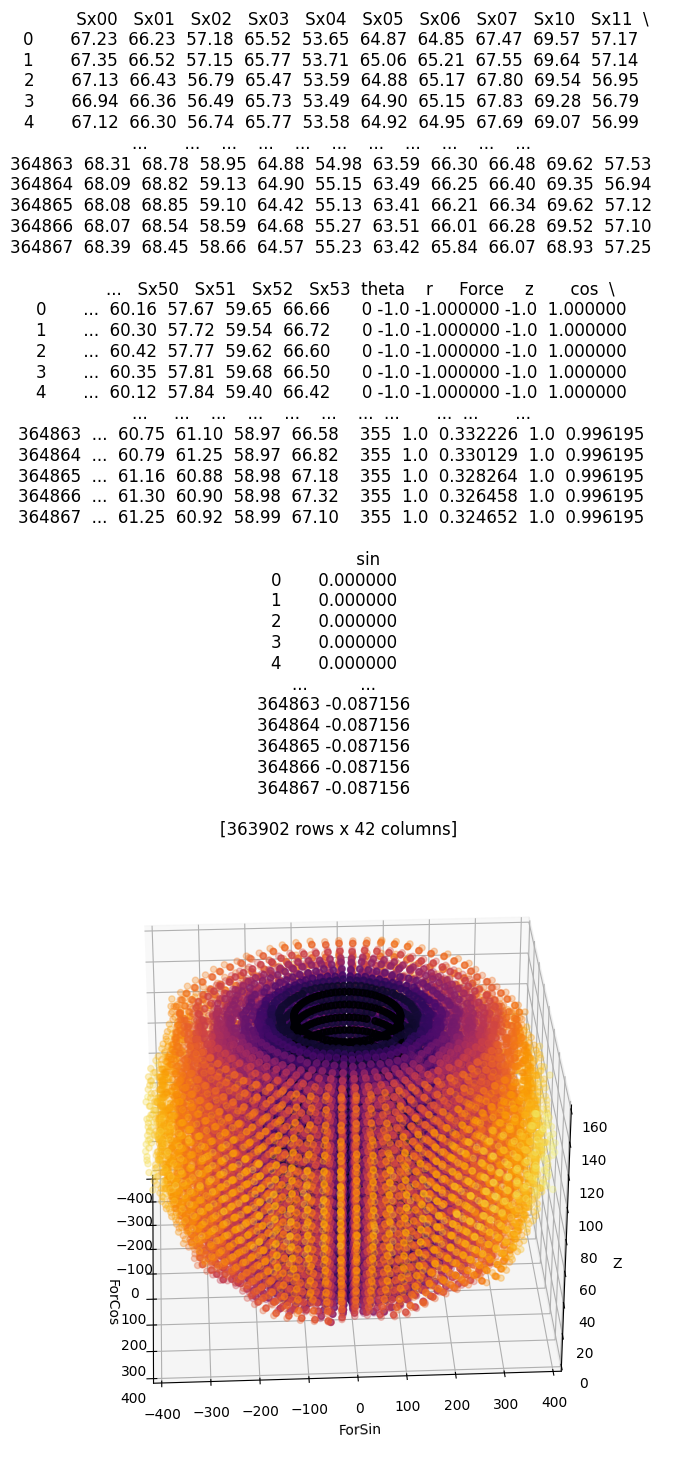

In [123]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()

# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 'Inferno' 색상 맵 적용
cmap = plt.cm.inferno

# z 값을 0과 1 사이로 정규화
norm_force = (ValidPre['force'] - ValidPre['force'].min()) / (ValidPre['force'].max() - ValidPre['force'].min())
norm_force = norm_force
# 색상 맵 적용
colors = cmap(norm_force)


# 최소값과 최대값
min_value = min_max_F[0]
max_value = min_max_F[1]

# 원래 값으로 변환
Force = ((ValidPre['force']/2+0.5) * (max_value - min_value)) + min_value  +110
cos = Force*ValidPre['cos']
sin =  Force*ValidPre['sin']
z = ((ValidPre['z']/2+0.5) * (min_max_Z[1] - min_max_Z[0])) + min_max_Z[0] 


ax.scatter(cos, sin, z, c=colors, alpha=0.3)

# 축 레이블 및 한계 설정
ax.set_xlabel('ForCos')
ax.set_ylabel('ForSin')
ax.set_zlabel('Z')
ax.set_xlim([-400, 400])
ax.set_ylim([-400, 400])
ax.set_zlim([0, 160])
ax.set_title(data)



 

# 애니메이션 생성 및 저장
nSteps = 3
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)

ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)
ani.save(os.path.join(output_dir, f"{dataname}_3d_scatter_Ref_force2.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))

# 결과 확인
plt.show()


진행 상태: 100.00%

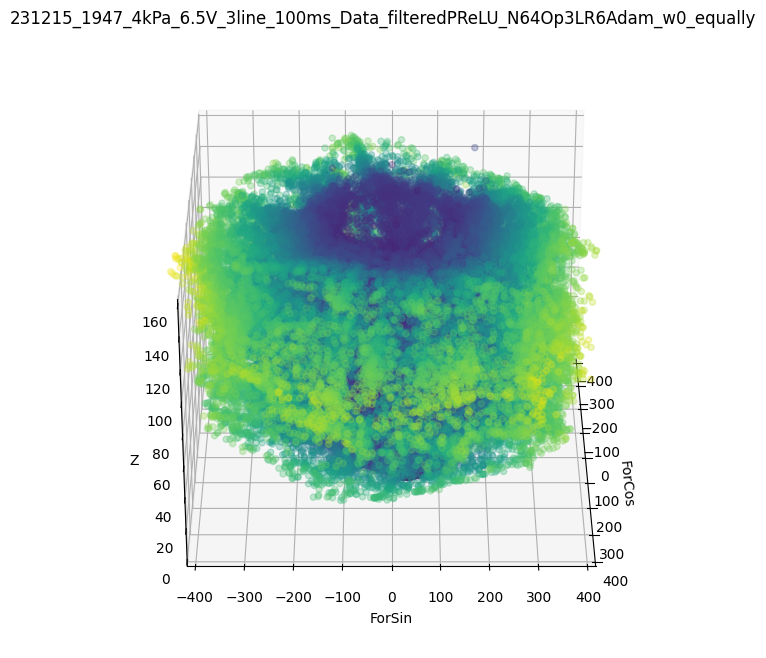

In [124]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import sys


# 회전 애니메이션 함수 정의
def rotate(angle):
    ax.view_init(30,azim=angle)
    
def update_progress(frame_number, total_frames):
    progress = (frame_number + 1) / total_frames * 100
    sys.stdout.write(f'\r진행 상태: {progress:.2f}%')
    sys.stdout.flush()

# 3D 그래프 생성
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 'Inferno' 색상 맵 적용
cmap = plt.cm.viridis

# z 값을 0과 1 사이로 정규화
norm_force = (ValidPre['valid_force'] - ValidPre['valid_force'].min()) / (ValidPre['valid_force'].max() - ValidPre['valid_force'].min())
norm_force =  norm_force

# 색상 맵 적용
colors = cmap(norm_force)


# 최소값과 최대값
min_value = min_max_F[0]
max_value = min_max_F[1]

# 원래 값으로 변환
Force = ((ValidPre['valid_force']/2+0.5) * (max_value - min_value)) + min_value  +110
cos = Force*ValidPre['valid_cos']
sin =  Force*ValidPre['valid_sin']
z = ((ValidPre['valid_z']/2+0.5) * (min_max_Z[1] - min_max_Z[0])) + min_max_Z[0] 


ax.scatter(cos, sin, z, c=colors, alpha=0.3)

# 축 레이블 및 한계 설정
ax.set_xlabel('ForCos')
ax.set_ylabel('ForSin')
ax.set_zlabel('Z')
ax.set_xlim([-400, 400])
ax.set_ylim([-400, 400])
ax.set_zlim([0, 160])
ax.set_title(dataname)



 

# 애니메이션 생성 및 저장
nSteps = 360
totalFrames =np.arange(0, 360, nSteps)
lenFrames = len(totalFrames)

ani = FuncAnimation(fig, rotate, frames=totalFrames, interval=nSteps*20)
ani.save(os.path.join(output_dir, f"{dataname}_3d_scatter_valid_force_color_2.gif"), dpi=200, writer='pillow',progress_callback=lambda i, n: update_progress(i, lenFrames))

# 결과 확인
plt.show()


In [ ]:
output_dir